# **Presentación de modelos predictivos**

## Requerimientos
1. Prediccion de variables climáticas con error cercano al 0%
2. En un lapso de tiempo de al menos 24 horas
3. Presentación de a lo menos cuatro modelos

**Opcionales:**

1. Generación de pronósticos a una semana
2. Determinación de condiciones como *nublado* o *soleado*

## Consideraciones

### R o Python
Si bien se posee mas experiencia de uso de R se decide ocupar Python puro para la creación de los modelos debido a la mayor disponibilidad de soporte y capacidad de paralelización de sus procesos (R sin paquetes externos no puede ocupar más de una núcleo por procesador), lo cual es determinante para acortar los tiempos de desarrollo y afinación de modelos

### Sobre set de datos
De ahora en adelante se usara el término "datos locales" para hacer referencia a los datos creados mediante registros de los sensores UTA Mayor y datos DGAC a aquellos descargados desde el portal web de Dirección General de Aeronáutica Civil, del mismo modo, se ocupan las siglas **Ts, HR y QFE** para hacer referencia a las variables **Temperatura, Humedad relativa y Presión atmosférica** respectivamente, por **date** o **utc** se hará referencia al **momento de captura** del registro.
Por **característica de tiempo** se hace referencia a los componentes (e.g. hora, dia, mes) de un momento de captura.

### Sobre este notebook y sus modelos
Este *notebook* genera modelos predictivos con fines meramente demostrativos y no representan la efectividad de los modelos actualmente funcionales dentro del servidor, sin embargo, conceptual y arquitectónicamente son iguales. La única diferencia entre los modelos generables aquí y los implementados es la cantidad de **epochs** especificados para aquellos algoritmos que utilizan tensorflow.

### Fórmulas de modelo: *Multivariable* y *multipaso*
Para ayudar al entendimiento de los  modelos, es que cada uno de ellos se asocian a una fórmula matemática, la cual describe la manera en que los datos de entrenamiento asocian sus *features* (predictores) y *labels* (predicciones), de la siguiente forma:
> Labels ~ Features

+ De esta manera, un modelo multivariable es aquel que es dado por la fórmula: 
    > Var1 + Var2 ~ Var3 + Var4
+ Es decir, múltiples variables de entradas son usadas para definir varias variables de salida. Estos modelos son conocidos como **MIMO** (*multiple input, multiple output*), en la formula presentada por ejemplo, las combinaciones de Var3 y Var4 (input) son usadas para predecir valores de Var1 y Var2 (output)
+ Un modelo autoregresivo es aquel dado por la fórmula: 
    > Var1 ~ Var1(n-1) + Var1(n-2) + ... + Var1(n-m)
+ Es decir, múltiples estados pasados (m) de una variable son usados para definir el estado actual o futuro de la misma variable. Estos modelos son denominados **autoregresivos**, y su mayor ventaja es la capacidad de generar pronósticos a largo períodos en el futuro si lo hacen *caminando* sobre sus predicciones, este concepto se conoce como **multipaso**. Por ejemplo: 
    - "*La temperatura de las 16hrs es predecida por las 6 horas de temperatura anteriores*" expresando esto como fórmula asignaria n=16 y m=6 respectivamente

### Sobre testeos
Dado los requerimientos del proyecto (predicción en tiempo real) es que se definen dos formas de testear el rendimiento de un modelo, una funcionalmente más importante que otra:

1. Test tradicional: Se evalúan las predicciónes hechas en base a un 10% del set de datos original reservados para el propósito de testear
2. Test de **autonomía**: Se evalúan las predicciones hechas en base a las mismas predicciones generadas por el modelo (multipasos), en otras palabras, el modelo para alcanzar horas lejanas en el futuro (como 5 horas en adelante) consume sus primeras 4 (horas) predicciones en forma de **pasos**

La definición de estas consideraciones se dan en base a experiencias registradas en este notebook, por lo que sus causas serán explicadas más adelante.

## Contexto
La confección de pronósticos climáticos es una disciplina antigua, pero que no se ejercía de forma metódica y precisa hasta la segunda mitad del siglo pasado, producto del empleo de herramientas como globos climáticos y comunicación por radio lo cual facilitaba el registro veraz y coordinado de ciertas variables atmosféricas en distintas zonas geográficas.
Construída esta base es que Edward Lorentz definió tres posibles paradigmas para la confección de pronósticos climáticos:

+ **Acercamiento dinámico**: El cual comprende la atmósfera como un gas el cual obedece las leyes de la física, y que mediante la definición de las ecuaciones que le gobiernan, se podrían determinar sus estados futuros y sus cambios conforme a alteraciones en sus variables **de entrada**. La desventaja de este paradigma es su lentitud y alto costo, pues requiere la acción coordinada de varias estaciones, en tiempo real, y poder computacional
+ **Acercamiento empírico**: Asume que las condiciones futuras del clima futuro serán similares a las presentadas en el pasado
    - Por ejemplo: Que el promedio de temperaturas de febrero del próximo año, será igual al febrero de este año
    - Mediante este paradigma se ampara el uso de ML para la creación de pronósticos, pues en base a eventos pasados, se puede generalizar con precisión el comportamiento de variables climáticas en el futuro. La desventaja de este enfoque es su incapacidad de predecir fenómenos no registrados o de rara ocurrencia
+ **Acercamiento dinámico-empírico**: Fusión de los paradigmas anteriores, es el acercamiento *de facto* para la creación de pronósticos, hasta hace unas décadas era representado por el algoritmo MS5, ahora por el WFR

### Sobre Machine Learning (ML)

Para entender este notebook se debe tener una noción de lo que es el ML y como funciona. En la siguiente lista, se explica algunos conceptos y el flujo de trabajo básico para lograr un modelo ML, este flujo fue efectivamente utilizado para la construcción de los modelos a presentar. Los pasos son los siguientes:

1. De un set de datos, se selecciona una variable a predecir o **label** y variables explicativas o **features** (o también **predictores**), como fórmula, lo anterior se puede expresar como: **label ~ features**
2. Se crea una arquitectura ML cuya primera labor es entranarse consuminedo **datasets de entrenamiento** compuesto de parejas de *features* y *labels*
3. La tarea de poder asignar o relacionar un valor *label* a cierta combinación de valores *features* se conoce como **mapeo** (la cual puede ser una regresión o clasificación), un modelo ML observa cientos de mapeos al consumir un dataset de entrenamiento, e intenta inferir patrones en estos
    > Un modelo ML generaliza, mediante la **detección de patrones** entre *features* y *labels*, los mapeos explicitados en su dataset de entrenamiento
4. El objetivo de entrenar un modelo ML es generar una **fórmula \[1\]** que **generalize** de la mejor manera posible los mapeos *predictor* -> *label* explicitados en el dataset de entrenamiento
5. Así como también aquellos nunca antes vistos, apartados en un **dataset de testeo**
6. La tarea de poder asignar un valor de una *variable a predecir* a cierta combinación de valores de *variables explicativas* se conoce como **predicción**

[1] En rigor, lo que un modelo genera no es una fórmula, sino una serie de matrices de transformaciones algebraicas que generalizan los mapeos *predictor* -> *label* explicitados en el dataset de entrenamiento

### Importado de librerías y cargando funciones de utilidad

In [1]:
# Uso universal
import os
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas
import sqlalchemy
import pymysql
import joblib
from math import sqrt
from sklearn.metrics import mean_squared_error

# 1er modelo
from statsmodels.tsa.arima.model import ARIMA
# 2do y cuarto modelo
import tensorflow as tf
# 3er modelo
from sklearn.ensemble import RandomForestRegressor

# funcion para crear caracteristicas de tiempo en base a una variable tipo *datetime*
def createTimeFeatures (dfToExpand):
    dfToExpand['minute'] = pandas.to_datetime(dfToExpand['utc']).dt.minute
    dfToExpand['hour'] = pandas.to_datetime(dfToExpand['utc']).dt.hour
    dfToExpand['day'] = pandas.to_datetime(dfToExpand['utc']).dt.day
    dfToExpand['month'] = pandas.to_datetime(dfToExpand['utc']).dt.month
    dfToExpand['year'] = pandas.to_datetime(dfToExpand['utc']).dt.year
    return dfToExpand

In [24]:
# El siguiente código se utilizá para hacer conexión a base de datos
# La variable *credentials* lee un archivo llamado 'pass' el cual debe ser creado conteniendo, en el siguiente orden y separados por un espacio simple ' ' : 
# usuario contraseña host nombreDeBaseDeDatos
# respectivamente, correspondientes a credenciales de la DB del servidor, todos los scripts '...Predictions' ocupan la misma forma de conexion
# Debido a que no es utilizado, esta seccion se encuentra comentada
### try:
###     credentials = np.genfromtxt("pass",dtype='str')
###     engine = sqlalchemy.create_engine("mysql+pymysql://"+credentials[0]+":"+credentials[1]+"@"+credentials[2]+"/"+credentials[3] )
###     mydb = engine.connect()
###     # haciendo retrieve de datos de los ultimos dos dias
###     query = "SELECT * FROM WEATHER_MEASUREMENT ORDER BY ID DESC LIMIT 34560;"
###     dfToPredict = pandas.read_sql(query,mydb)
### except:
###     mydb.close() 
###     print("error conexion a db")

# **Iteración uno: Modelo RF preliminar** (fallida)
Con el fin de obtener de forma inmediata una línea base de efectividad a mejorar mediante la creación de nuevos modelos a la vez que un acercamiento al uso de Python para el ML, es que se inicia este proceso construyendo un bosque aleatorio **(RF)** simple que consuma los datos locales de forma cruda, este algoritmo es de especial utilidad para esta tarea puesto a que no requiere la afinación de hiperparámetros (como si los requeriría una red neuronal **-DNN-**), ni preprocesamiento de datos importante

## Preparación de datos
Esta iteración se destaca por el escaso preprocesamiento de datos al alimentar el modelo

**Selección de datos**: Datos completamente locales (~100.000 aprox.)

**Limpieza de datos**: No aplica, por el contrario no existen valores nulos en los datos locales pues son generados mediante un proceso metódico y automatizado (sensores) por lo tanto de esta iteración en adelante se omite este paso

## Modelado
+ Fórmula: Ts ~ HR + QFE + date (Label: columna Ts , predictores: columnas HR, QFE y date)
+ Algoritmo seleccionado: RF

## Evaluación
El modelo no se pudo concretar
+ El consumo de recursos computacionales es excesivo
+ La predicción de una variable climática cada 5 segundos puede resultar innecesaria considerando que se ha de generar pronósticos a una semana en el futuro
    - Esto resultaría en 168\*60\*12 predicciones, es decir ~121.000 registros por modelo
+ Los *predictores* (HR + QFE + date) están mal definidos, pues para determinar el valor de una variable climática en el futuro solo se cuenta con un *momento* (e.g: '2021-10-11 12:00:00) y no con valores de HR o QFE
> por lo tanto una predicción 'Ts ~ HR + QFE' es inviable, en cambio y por ejemplo, una predicción del tipo 'Ts(n+10) ~ HR(n) + QFE(n)', siendo 'n' representado por la hora actual, es viable

Este problema se puede solucionar eliminando del set de datos de entrenamiento las variables HR y QFE, pero genera otros inconvenientes.
Solo se cuenta con datos tipo fecha, los cuales en este formato se comportan como un escalar (e.g: valores de 0 a 365 con pasos de uno en uno) lo cual puede no ser útil para la detección de patrones por parte de los modelos. Ante esta situación se plantean tres opciones:
    
1. Si se asume que para alimentar al modelo solo se cuenta con **momentos (o fechas)** pasadas para pronósticos futuros, se podría aplicar análisis de **series de tiempo** en los datos, y por tanto todas las herramientas ya desarrolladas para este tipo de fenómenos
    > Fórmula: Ts(n) ~ Ts(n-1) + Ts(n-2) + ...
2. Por otra parte, la descomposición de fechas en **características de tiempo**, es decir, minutos, horas, días y meses, es intuitivamente útil, pues si el modelo logra relacionar por ejemplo el promedio de temperaturas de julio con un valor más bajo que el promedio de junio, se obtendría un pronóstico básico (pues solo mape una hora+dia+mes a cierta temperatura de cada año), pero funcional
    > Fórmula: Ts(n) ~ H + D + M 
3. Por último, apegándose mas a la definición de *acercamiento empírico*, se asume que las condiciones climáticas futuras son definidas de forma importante por las condiciones pasadas, por lo tanto se puede construir un **mapeo** de una serie de condiciones pasadas (incluyendo HR y QFE) a un momento futuro de éstas mismas variables
    > Fórmula: Ts(n) ~ Ts(n-1) + HR(n-1) + QFE(n-1)

> *Nota*: Todas estas fórmulas pueden aplicarse en su forma multivariable (**MIMO**) en cuanto el algoritmo a ocupar lo permita, por lo tanto una fórmula del tipo (Ts+HR+QFE)(n) ~ H + D + M es perfectamente válida

# **Iteración dos: Modelo DNN** (fallida)
Tomando en cuenta la evaluación del modelo anterior es que en esta iteración se comienza a hacer preprocesamiento de datos, proceso el cual también conlleva a tomar decisiones en un contexto de **costo-beneficio**, pues la construcción y formateo de datos estará alterando la ***realidad*** registrada por los sensores en pos de alimentar a los modelos ML con información la cual sea consistente y eficiente de procesar en vez de *real*. La estrategia de preprocesamiento en esta iteración corresponde a una mezcla entre las opciones **2 y 3** de la sección anterior

## Preparación de datos
**Selección de datos**: Para disminuir el uso de recursos computacionales se decide hacer **agrupamiento de los registros** por minuto, disminuyendo 12 veces el tamaño del dataset original. 

**Construcción**: El agrupamiento de datos por medio de minutos reveló **gaps** entre los registros, los cuales deben ser rellenados si se desea aplicar el método 3 pues, por ejemplo, una temperatura de las 8am podría ser definida por la Ts de las 1am, último Ts registrado antes de un periodo de baja del servicio. En python esta operación se denomina **interpolado**

**Formateo**: Para las redes neuronales, este es un paso obligatorio, las transformaciones que han de aplicarse para alimentar una DNN de *tensorflow* incluye:

+ Descomposición de tiempo: La DNN es incapaz de procesar datos tipo *date*    
+ Interpolado: La DNN es incapaz de procesar datos nulos
+ Normalización: Las DNN son sensibles a los valores fuera de un rango (-1,1) pues valores muy altos pueden falsamente anunciarse como cambios de alta importancia y propagarse entre las neuronas a pesar de ser simplemente el promedio de una variable (e.g: la Ts promedio que es 19 grados vs la QFE promedio que es 1010 hPac)

## Modelado
+ Características del modelo: Mutlivariable
+ Fórmula: Ts(n) ~ Ts(n-1) + min + H + D + M (la temperatura de hace una hora mas la hora, dia y mes determinan la temperatura de la hora actual)
+ Algoritmo seleccionado: DNN, 4 capas densas, Entradas \[7,] -> Salida\[3]

In [40]:
# Preparación de datos
## Seleccion
df = pandas.read_csv("./WEATHER_MEASUREMENT.csv")
df["utc"] = pandas.to_datetime(df["dateUTC"],format='%Y-%m-%d %H:%M:%S')
df = df.groupby(pandas.Grouper(key="utc",freq='min')).mean()    
toKeep = ['AMBIENT_TEMPERATURE','AIR_PRESSURE','HUMIDITY']
df = df[toKeep]

In [41]:
## Construcción
df = df.interpolate(method = 'linear')
df = df.reset_index()
df.columns = ['utc','Ts_Valor','QFE_Valor','HR_Valor']
df = df[['Ts_Valor','HR_Valor','QFE_Valor','utc']]
## Formateo
df = createTimeFeatures(df)
dates_df = df.pop('utc')
df.pop('year')
## Normalizado (manual)
train_mean = df.mean()
train_std = df.std()
df = (df - train_mean) / train_std

In [42]:
# Modelado
## Creación de *labels* para utilizar como resultados de fórmula
topred = df[['Ts_Valor','HR_Valor','QFE_Valor']]
topred = topred[1:]
topred = topred.reset_index(drop=True)
# topred = (topred - train_mean[['Ts_Valor','HR_Valor','QFE_Valor']]) / train_std[['Ts_Valor','HR_Valor','QFE_Valor']]
df = df[:-1]

In [43]:
## Creación datasets de entrenamiento y testeo
lendf = len(df)
lendf = round(lendf*0.9)
train_df = df[0:lendf]
train_labels = topred[0:lendf]
test_df = df[lendf:len(df)]
test_labels = topred[lendf:len(df)]

In [ ]:
#topred.tail()
#topred.shape

In [ ]:
#df.tail()
#df.shape

In [44]:
# Modelado
features = test_df.shape[1]
train_df = np.array(train_df)
test_df = np.array(test_df)
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

nnHM = tf.keras.Sequential()
nnHM.add(tf.keras.layers.Dense(168,input_shape=(features,)))
nnHM.add(tf.keras.layers.Dense(72,input_shape=(features,)))
nnHM.add(tf.keras.layers.Dense(24,activation='relu'))
nnHM.add(tf.keras.layers.Dense(3))
# nnHM.predict(test_df)

In [45]:
## Compilado de modelo
nnHM.compile(
    optimizer=tf.optimizers.Adam(),
    #learning_rate = 0.001
    loss='mae', # 'mean_absolute_error',
    metrics=[tf.keras.metrics.MeanSquaredError()] 
)
history = nnHM.fit(
    train_df, train_labels,
    epochs=3,
    verbose=1,
    shuffle=False,
    validation_split=0.15
)

2021-08-13 01:53:06.312139: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-13 01:53:06.385120: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2594920000 Hz
Epoch 1/3
1172/1172 [==============================] - 14s 10ms/step - loss: 0.1613 - mean_squared_error: 0.0772 - val_loss: 0.2987 - val_mean_squared_error: 0.1452
Epoch 2/3
1172/1172 [==============================] - 11s 10ms/step - loss: 0.1058 - mean_squared_error: 0.0369 - val_loss: 0.1927 - val_mean_squared_error: 0.0605
Epoch 3/3
1172/1172 [==============================] - 14s 12ms/step - loss: 0.0847 - mean_squared_error: 0.0252 - val_loss: 0.2695 - val_mean_squared_error: 0.1718


In [48]:
# Testeo tradicional
x = nnHM.predict(test_df)
stackPreds = pandas.DataFrame(x)
stackPreds.columns = ['Ts_Valor','HR_Valor','QFE_Valor']
test_labels = pandas.DataFrame(test_labels)
test_labels.columns = ['Ts_Valor','HR_Valor','QFE_Valor']
test_labels = test_labels.reset_index(drop=True)

In [49]:
# De-normalizacion
stackPreds = stackPreds * train_std + train_mean
test_labels = test_labels * train_std + train_mean
#stackPreds.plot(subplots=True)
#test_labels.plot(subplots=True)
#plt.show()

In [50]:
# En caso de error, comentar la siguiente línea para que las gráficas se muestren embebidas, para hacer zoom, abrá que modificar la cantidad de registros a *plotear*, se sugiere mostrar de 0 a 72 registros
%matplotlib qt
plt.plot(stackPreds['Ts_Valor'],label="Predicciones DNN")
plt.plot(test_labels['Ts_Valor'],label="Test Labels")
plt.title("Predicciones de temperatura - Modelo DNN - Fórmula: (Ts+HR+QFE)(n) ~ (Ts+HR+QFE)(n-1) + TimeFeatures")
plt.ylabel("Temperatura (°C)")
plt.xlabel("Cantidad de minutos en el futuro")
plt.legend()
plt.grid()
plt.show()

## Evaluación
A primera vista pareciera que el modelo tiene una alta capacidad predictiva debido a los errores promedio cercanos a cero en el **test tradicional**, considerando la varianza original de los datos. Lo cual se confirma al apreciar la cercanía entre las líneas dibujadas por las predicciones y el dataset de testeo, sin embargo, al momento de implementar el modelo, detectamos un error conceptual en la construcción de este:
A continuación, los resultados del test tradicional:

In [51]:
a = stackPreds - test_labels
a.mean()

HR_Valor    -0.301874
QFE_Valor    0.882426
Ts_Valor     0.676303
day               NaN
hour              NaN
minute            NaN
month             NaN
dtype: float64

## Implementación
Obedeciendo la fórmula de este modelo: **Ts(n) ~ Ts(n-1) + min + H + D + M**

Es que las predicciones que este genera deben ser retroalimentadas como *input* para la generación de una siguiente predicción o **paso**, es decir, se procede a aplicar un **test de autonomía**,en este momento es donde el modelo falla de forma evidente como se puede ver en la siguiente gráfica

In [52]:
# Testeo de autonomía
# Se inicia obteniendo y normalizando el último registro del dataset original, pues si esta modelo funcionara en tiempo real, solo contaría con registros de variables hasta el momento en que se realiza la predicción del modelo
r = [18.955,55.959,1012.699,0,0,1,8]
r = pandas.DataFrame(r).transpose()
r.columns = ['Ts_Valor','HR_Valor','QFE_Valor','minute','hour','day','month']
r = (r-train_mean)/train_std
r = r[['Ts_Valor','HR_Valor','QFE_Valor','minute','hour','day','month']]
r

,Ts_Valor,HR_Valor,QFE_Valor,minute,hour,day,month
0,-0.564649,1.005445,1.379337,-1.703241,-1.662508,-1.770372,3.187065


In [53]:
now = pandas.to_datetime('2021-07-29 18:00:00')
features = test_df.shape[1]
x = nnHM.predict(r)
stackPreds = pandas.DataFrame()
for i in range(20):
    delta = now + datetime.timedelta(0,i*60)
    #temp = np.array([x,y,z,delta.hour,delta.day,delta.month],dtype="float32")
    temp = np.array([x[0,0],x[0,1],x[0,2],delta.minute,delta.hour,delta.day,delta.month],dtype="float32")
    stackPreds = stackPreds.append(pandas.DataFrame(temp).transpose())
    # Formateando registro para alimentar el modelo
    temp_RE = np.reshape(temp,(-1,features))
    x = nnHM.predict(temp_RE)

stackPreds.columns = ['Ts_Valor','HR_Valor','QFE_Valor','minute','hour','day','month']
stackPreds = stackPreds * train_std + train_mean
stackPreds = stackPreds.reset_index(drop=True)

In [ ]:
test_labels = test_labels.reset_index(drop=True)
plt.plot(stackPreds['Ts_Valor'],label="Predicciones DNN")
plt.plot(test_labels[['Ts_Valor']],label="Test Labels")
plt.title("Predicciones de temperatura - Modelo DNN - Fórmula: (Ts+HR+QFE)(n) ~ (Ts+HR+QFE)(n-1) + TimeFeatures")
plt.ylabel("Temperatura (°C)")
plt.xlabel("Cantidad de minutos en el futuro")
plt.legend()
plt.grid()
plt.show()

La falla de este modelo recae en su fórmula **Ts(n) ~ Ts(n-1) + min + H + D + M** , la cual indica que todas las predicciones son mayormente dependientes de sus valores inmediatamente anteriores (Ts(n) ~ Ts(n-1)) y además al hecho de haber aprendido en mayor parte el **comportamiento lineal** de los datos, el cual fue inducido al momento de hacer interpolado con tal de obtener un dataset consistente.

Ante la incapacidad de los modelos de retroalimentarse y generar predicciones fiables no tan dependientes de los registros inmediatamente anteriores captados se idea una serie de formas posibles de apalear los efectos de este fenomeno y se comentan sus posible desventajas:
+ **No proveer de la varible minuto a los registros**: Considerando que las predicciones:
    1. O son incapaces de entender los minutos como un simple componente de hora, es decir que los minutos de la hora 16 tienen distinto comportamiento que los minutos de la hora 3 am
    2. O la variable minuto simplemente provee rigidez al modelo, debido a su comportamiento lineal, lo cual lo hace incapaz de reconocer la mayor importancia de mapear en 1er lugar e.g: hora -> temperatura
+ Agrandar los gaps entre los registros: A hora o días, pues los comportamientos lineales de los tiempos de downtime son *extensos* considerando la granularidad de los registros, lo cual afecta negativamente la deteccion de periodicidad en los datos
    > Una iteración 2.5 demostró que esta solución no es viable, los datos son insuficientes como para detectar cualquier patrón
+ **Mejorar interpolacion**: Preferentemente mediante una funcion sinusoidal que imite los ciclos naturales diarios de las variables climáticas
    1. Imposible aplicar para humedad relativa con datos locales, su comportaminento es muy errático
    2. Disponibilidad: se requiere al menos un par de dias de registros sin downtime o integración de datos externos
    3. Alta complejidad: pues requeriria ya un modelo de prediccion funcional tan solo para hacer preprocesamiento
+ **Integración de datos**: Dgac y locales, sobreescribiendo los datos locales en los datos Dgac, de esta forma los modelos tienen mayor espacio para aprender los ciclos de las variables
    1. Se perderia una enorme cantidad de datos (720 veces menos datos)
+ Mapeos mas extensos: Conocido también como **sistema de ventanas**, consiste en relacionar una mayor cantidad de *features* por cada *label*
    + e.g: matriz6horasDeDatos[][] -> prediccion1hora[]
    + Input \[24]\[6] -> Output \[1]\[3]

Tomando en cuenta los aprendizajes obtenidos mendiante la visualización de datos es que se opta por aplicar soluciones incluyendo los puntos 1, 4 y 5, y retomando las opciones 1 y 2 mencionadas en la iteración uno, las cuales no empleaban variables que requieren retroalimentación, pues dependen únicamente de la fecha de los registros y comportamientos cíclicos *univariables*

# **Iteración tres: Modelo ARIMA**
Un modelo autorregresivo de promedio móvil integrado (ARIMA) es un modelo estadístico que utiliza variaciones y regresiones de datos estadísticos con el fin de encontrar patrones para una predicción hacia el futuro [\[1\]](https://es.wikipedia.org/wiki/Modelo_autorregresivo_integrado_de_media_m%C3%B3vil) .

Este tipo de modelos son *univariables* pero requieren que el usuario indique, como mínimo, la periodicidad percibida de la serie de tiempo a estudiar, como se conoce que la mayoría de variables climáticas dibujan ciclos de 24 horas de acuerdo a las horas del día, se puede construir un modelo ARIMA por cada variable [\[2\]](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/).

## Preparación de datos
**Selección de datos**: Últimos dos días de registros locales (~35.000 aprox.) agrupados por hora.
> Una iteración 3.5 demostró que el uso de dataset de agrupados por minuto genera una excesiva carga computacional y tamaño de modelo (~ 2 gb) 

**Construcción**: Interpolado lineal 

**Formateo**: Tarea extensa debido al tipo de index el cual consume el modelo, que debe ser de tipo *date* con frecuencia horaria explicitada, el cual además para subir a DB, debe pasar por un proceso inverso.

## Modelado
+ Fórmula: Ts(n) = Ts(n-1) + Ts(n-2) + ... + Ts(0)
+ Algoritmo: ARIMA del paquete 'statsmodels' (en rigor es un SARIMAX), periodicidad cada 24 registros y grado de integración 1.

In [14]:
df = pandas.read_csv("./dataPreprocessed.csv",parse_dates=['utc'],index_col=['utc'])
# Manteniendo últimos dos dias de registros
lendf = len(df)
df = df[-120:-48]
series = df.copy()
series.index = series.index.to_period('H')

In [9]:
series

,Ts_Valor,HR_Valor,QFE_Valor
utc,,,
2021-07-28 00:00,15.00,68.00,1013.30
2021-07-28 01:00,15.10,67.00,1013.90
2021-07-28 02:00,14.90,67.00,1014.30
2021-07-28 03:00,14.80,68.00,1014.50
2021-07-28 04:00,14.70,68.00,1014.40
2021-07-28 05:00,14.60,68.00,1014.20
2021-07-28 06:00,14.60,69.00,1014.00
2021-07-28 07:00,14.40,68.00,1013.10
2021-07-28 08:00,14.20,68.00,1012.40


Una de las mejores caracteristicas de los modelos ARIMA (o al menos su implementacion en pyhon) es que puede hacer bulk de predicciones con tan solo un valor futuro fijo de la serie de tiempo (o sea una fecha futura arbitraria), dependiendo complemente de los ultimos steps que el mismo modelo va creando, los cuales su varianza va disminuyendo a través del tiempo, convergiendo las prediccioes en el promedio de las variables.


In [15]:
future = 72

stackPreds = pandas.DataFrame()
model = ARIMA(series['Ts_Valor'], order=(24,1,0))
model_fit = model.fit()
stackPreds['Ts_Valor'] = model_fit.forecast(future)
model = ARIMA(series['HR_Valor'], order=(24,1,0))
model_fit = model.fit()
stackPreds['HR_Valor'] = model_fit.forecast(future)
model = ARIMA(series['QFE_Valor'], order=(24,1,0))
model_fit = model.fit()
stackPreds['QFE_Valor'] = model_fit.forecast(future)

## Evaluación

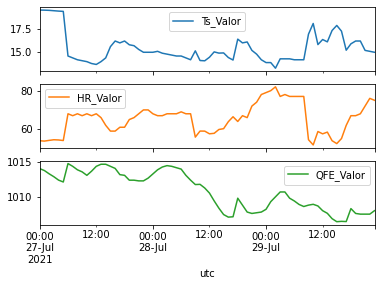

In [16]:
series.plot(subplots=True)
plt.show()

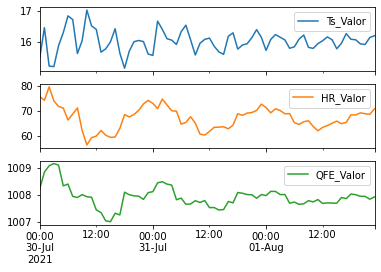

In [17]:
stackPreds.plot(subplots=True)
plt.show()

Como se puede observar, el modelo genera gráficas que en mayor parte se asemejan a los comportamientos de las variables que le fueron proveídas, el principal objetivo de esta iteración fue alcanzado pues se construyó un modelo el cual puede consumir sus propias predicciones como input y dar *pasos en el futuro* de forma estable

# **Iteración cuatro: Modelo DNN - solo tiempo**
Continuando con la premisa del modelo ARIMA (es decir, el valor actual de las variables dependen únicamente de sus momentos pasados) es que mediante un modelo DNN, adaptamos esta premisa a los algoritmos de aprendizaje automáticos modernos. De esta forma, de forma computacional, la variable a predecir ya no consume un bulk de sus estados pasados, sino simplemente fechas-horas pasadas, por lo que se construye un mapeo 
> Momento (pasado o futuro) -> Variable

El cual generalize de mejor manera los mapeos "momento -> valor_variable" pasados. De esta forma los nuevos *inputs* del modelo se convierten en **características de tiempo** como hora, día y mes, los cuales siempre existirán y no requieren que el modelo consuma sus propias predicciones
A diferencia de ARIMA, un DNN construído de forma manual en *tensorflow* puede ser de *output* multivariable, y además se puede controlar con precisión los comportamientos internos de la red neuronal como la cantidad de capas y forma de activación.

## Preparación de datos
**Selección de datos**: Proveer de datos consistentes y extensos es de vital importancia en el aprendizaje automático y en especial para las redes neuronales por lo que se emplean todos los registros locales disponibles agrupados por hora y además se hace selección de datos externos para complementar

**Construcción**: Sabiendo que los gaps de nuestros datos locales van a ser suplidos por externos, este paso no aplica de aquí en adelante

**Integración**: Se integran datos externos proveídos por DGAC de 2019 y 2020 para rellenar nuestros registros faltantes, este paso se aplica para todas las iteraciones de aquí en adelante

**Formateo**: Incluye descomposición de tiempo y normalización 

## Modelado
+ Fórmula: Ts(n) ~ H + D + M , en su versión multivariable (Ts+HR+QFE)(n) ~ H + D + M
    - Se omite el uso de año (Y) pues en una iteración 4.5 se probó que este atributo solo proveía pérdida de varianza a los pronósticos en vez de expresar una tendencia o estacionalidad significativa
    - H, D y M se expresan como **constantes** en la fórmula pues existen solo 24, 31 y 12 posbiles valores para cada variable respectivamente, por lo que actúan más de forma *categórica* que *continua*. Además existen solo 8760 posibles combinaciones de H + D + M

+ Algoritmo: Stack de 5 capas de redes neuronales densas (*fully connected neurons* sin métodos internos)

In [18]:
df = pandas.read_csv("./dataPreprocessed.csv")
df = createTimeFeatures(df)
df = df[['Ts_Valor','HR_Valor','QFE_Valor','hour','day','month']]

lendf = len(df)
lendf = round(lendf*0.998)
train_df = df[0:lendf]
test_df = df[lendf:len(df)]

varToPred = 'Ts_Valor'
varToPred = ['Ts_Valor','HR_Valor','QFE_Valor']
train_labels = df[varToPred][0:len(train_df)]
test_labels = df[varToPred][lendf:]

# salvando valores de test para autoregresiones
rtTest = test_df.copy()
rtTest_labels = test_labels.copy()

train_mean = train_df.mean()
train_std = train_df.std()
train_df = (train_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std
train_labels = (train_labels - train_mean[varToPred]) / train_std[varToPred]
test_labels = (test_labels - train_mean[varToPred]) / train_std[varToPred]

train_df = train_df[['hour','day','month']]
test_df = test_df[['hour','day','month']]
features = train_df.ndim + 1

In [19]:
train_df = np.array(train_df)
#test_df = np.array(test_df)
train_labels = np.array(train_labels)
#test_labels = np.array(test_labels)

nnHM = tf.keras.Sequential()
nnHM.add(tf.keras.layers.Dense(672,input_shape=(3,)))
nnHM.add(tf.keras.layers.Dense(168,activation='relu'))
nnHM.add(tf.keras.layers.Dense(72,activation='relu'))
nnHM.add(tf.keras.layers.Dense(24,activation='relu'))
nnHM.add(tf.keras.layers.Dense(3))

2021-08-30 00:13:02.522221: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-08-30 00:13:02.535668: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [20]:
nnHM.compile(
    optimizer=tf.optimizers.Adam(),
    #learning_rate = 0.001
    loss='mae', # 'mean_absolute_error',
    metrics=[tf.keras.metrics.MeanSquaredError()] 
)
history = nnHM.fit(
    train_df, train_labels,
    epochs=2,
    verbose=1,
    shuffle=False,
    validation_split=0.15
)

2021-08-30 00:13:03.893818: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-30 00:13:03.924608: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2595090000 Hz
Epoch 1/2
832/832 [==============================] - 11s 11ms/step - loss: 0.5795 - mean_squared_error: 0.5725 - val_loss: 0.8626 - val_mean_squared_error: 1.1380
Epoch 2/2
832/832 [==============================] - 8s 9ms/step - loss: 0.5604 - mean_squared_error: 0.5407 - val_loss: 0.8232 - val_mean_squared_error: 1.0208


In [335]:
#x = nnHM.predict(test_df)
nnHM = tf.keras.models.load_model('../deepNN-multiV2')
x = nnHM.predict(test_df)

stackPreds = pandas.DataFrame(x)
stackPreds.columns = ['Ts_Valor','HR_Valor','QFE_Valor']
test_labels = pandas.DataFrame(test_labels)
test_labels.columns = ['Ts_Valor','HR_Valor','QFE_Valor']

In [336]:
stackPreds = stackPreds * train_std + train_mean
test_labels = test_labels * train_std + train_mean
stackPreds = stackPreds.reset_index(drop=True)
test_labels = test_labels.reset_index(drop=True)

## Evaluación

In [337]:
plt.plot(stackPreds['Ts_Valor'],label="Predicciones")
plt.plot(test_labels['Ts_Valor'],label="Test Labels")
plt.title("Predicciones de temperatura - Modelo DNN - Fórmula: Ts ~ h + d + m")
plt.ylabel("Temperatura (°C)")
plt.xlabel("Horas en el futuro desde el 31-07 03:00")
plt.legend()
plt.grid()
plt.show()

In [338]:
plt.plot(stackPreds['HR_Valor'],label="Predicciones")
plt.plot(test_labels['HR_Valor'],label="Predicciones")
plt.legend()
plt.grid()
plt.title("Predicciones de humedad relativa - Modelo DNN - Fórmula: HR ~ h + d + m")
plt.ylabel("Humedad relativa (%)")
plt.xlabel("Horas en el futuro desde el 31-07 03:00")
plt.show()

In [339]:
a = ((stackPreds - test_labels) * (stackPreds - test_labels)).mean()
a

HR_Valor     42.595942
QFE_Valor     3.570640
Ts_Valor      0.897967
day                NaN
hour               NaN
month              NaN
dtype: float64

Como se puede observar, el modelo genera gráficas que en mayor parte se asemejan a los comportamientos de las variables en el set de datos de testeo, sin embargo cabe mencionar ciertas observaciones a mejorar en futuras iteraciones:
+ Las predicciones tienen un comportamiento de **señal** más que alguno de fenómeno natural. Esto se debe a que:
    - El modelo consume variables estáticas, es decir a través de los años los componentes **H, D y M** siempre tienen el mismo comportamiento (ir de 1 a 24, 1 a 30 y 1 a 12 respectivamente), por lo que en resumen, el modelo no hace mas que **mapear los mejores promedios a distintos momentos del año**
    - Este fenómeno era esperable dada la fórmula que define el modelo, el cual consume valores constantes
+ Los valores de error promedio calculado van en conjunto con lo expuesto, pues en visualizaciones de datos preliminares ya se observaba que las variables Ts y QFE tenían un comportamiento cíclico rígido y, por el contrario, HR era la variable con más ruido

De esta forma, esta iteración confirma la **importancia** que tiene el alimentar al modelo con registros de variables pasadas, esta vez, abasteciendo con suficientes datos históricos con diferencias significantes para privilegiar la detección de **ciclos (o estacionalidad)** y en segundo lugar el efecto de registros inmediatemente anteriores sobre la predicción final.

> Una solución alternativa, pero que conceptualmente no es diferente a lo desarrollado en esta iteración, es el forzar el comportamiento de señal en las variables, mediante la aplicación de transformaciones tipo **H = sin(H)** y **D + M = sin(D + M)** con tal de explicitar los ciclos diarios y anuales de cada variable

# **Iteración cinco: Modelo RF**
Tomando en cuenta la evaluación de la iteración pasada, es que esta vez el modelo a generar debe captar ciclos de variables (como la DNN anterior) a la vez que ser sensible a los valores inmediatamente anteriores de otras condiciones climáticas (como un ARIMA multivariable, pero de 48 veces menos *look-back*).

Por lo que para esta iteración se retoma la fórmula Ts(n) ~ Ts(n-1) + min + H + D + M pero eliminando el componente minutos e incrementando la cantidad de información de entrenamiento mediante la integración de datos de DGAC
Para entender de mejor manera los nuevos predictores es que se muestra la fórmula que rige este modelo junto a las fórmulas de modelos anteriores:
Siendo 'n' la representación de la hora actual
+ ARIMA:        Ts(n) ~ Ts(n-1) + Ts(n-2) + ... + Ts(n-48)
+ DNN:          Ts(n) ~ H + D + M                               (notese la ausencia de algún comoponente hora-dependiente)
+ RF(nuevo):    Ts(n) ~ Ts(n-1) + H + D + M

Hipoteticamente se espera que esta relación 'label~predictor' sea capaz de detectar el comportamiento cíclico de las variables climáticas
(mediante h+d+m) y capaz también de influenciar cada prediccion mediante la temperatura que le precede (mediante Ts(n-1))

La afinación de una regresión y el modelo detrás de este es un proceso costoso computacionalmente a la vez que inestable, problemas propios de las redes neuronales como *exploding/vanishing gradient* fueron presensiados en iteraciones pasadas pero no mencionadas para mantener el *notebook* fluido, al mismo tiempo, las diferentes formas de normalizar e interpolar datos añaden mayor complejidad y variables que deben ser meticulosamente traceadas y guardadas al momento de creación de un modelo NN.
Ante estas dificultades es que se vuelve a aplicar un modelo RF, el cual no presenta los problemas descritos pues simplemente divide y promedia la serie de árboles de decisión que construye para generar una regresión

## Preparación de datos
**Selección de datos**: Datos locales y DGAC (2 años) agrupados por hora

**Integración**: Se escribe nuestros datos locales sobre los registros DGAC mediante una operación *join&replace*

**Formateo**: Descomposición de tiempo

## Modelado
+ Fórmula: Ts(n) ~ Ts(n-1) + H + D + M
    - Estrictamente: Ts(n) + HR(n) + QFE(n) ~ Ts(n-1) + HR(n-1) + QFE(n-1) + H +D + M
+ Algoritmo seleccionado: RF, su implementación en python permite *output* multivariable (Entradas \[7,] -> Salida\[3]) a la vez que sistema por ventanas

In [340]:
# Seleccion e integración
df = pandas.read_csv("./dataPreprocessed.csv")
df = createTimeFeatures(df)
df.pop('minute')
df.pop('year')
dates_df = df.pop('utc')

# Preparación de datos y labels para cumplir con fórmula
topred = df[['Ts_Valor','HR_Valor','QFE_Valor']]
topred = topred[1:]
df = df[:-1]

# Dividiendo dataset
lendf = len(df)
lendf = round(lendf*0.9)
train_df = df[0:lendf]
train_labels = topred[0:lendf]
test_df = df[lendf:len(df)]
test_labels = topred[lendf:len(df)]

In [341]:
rfMultivar = RandomForestRegressor()
rfMultivar.fit(train_df,train_labels)

predRF = rfMultivar.predict(test_df)
test_df = test_df.reset_index(drop=True)

## Evaluación
Mediante testeo tradicional:

In [343]:
a = ((predRF - test_df[['Ts_Valor','HR_Valor','QFE_Valor']]))
a.mean()

Ts_Valor     0.095336
HR_Valor     0.051294
QFE_Valor   -0.002888
dtype: float64

Se omitirá la presencia de gráficas resultantes de **testeo tradicional** debido a que el principal requerimiento del proyecto y objetivo de este modelo es demostrar un comportamiento autoregresivo estable mediante consumo de sus propias predicciones conservando la estacionalidad de las variables climáticas, este plan de evaluación se conoce como **test de autonomía** y resultó en las siguientes predicciones:

In [344]:
now = datetime.datetime.now()
now = pandas.to_datetime('2021-07-29 09:00:00')
stackPreds = pandas.DataFrame()
x = rfMultivar.predict(train_df[len(train_df)-1:])

In [345]:
for i in range(0,72):
    # Mediante cada iteración, se agregan 3600 segundos (1 hora) a la fecha definida por 'now'
    delta = now + datetime.timedelta(0,i*3600)
    # Se guarda en una variable temporal, las predicciones generadas por el modelo y junto a la nueva fecha 'delta'
    temp = np.array([x[0,0],x[0,1],x[0,2],delta.hour,delta.day,delta.month,delta.year],dtype="float32")
    # Se añade al stack de predicciones la prediccion generada para esta iteración
    stackPreds = stackPreds.append(pandas.DataFrame(temp).transpose())
    # Formateando registro para alimentar el modelo
    temp_RE = np.reshape(temp,(-1,7))
    x = rfMultivar.predict(temp_RE)

In [346]:
stackPreds = stackPreds.reset_index(drop=True)
test_labels = test_labels.reset_index(drop=True)
stackPreds.columns = ['Ts_Valor','HR_Valor','QFE_Valor','h','d','m','y']
stackPreds = stackPreds[['Ts_Valor','HR_Valor','QFE_Valor']]

In [347]:
stackPreds.plot(subplots=True)
test_labels.plot(subplots=True)
plt.show()

In [348]:
x = ((stackPreds - test_df[['Ts_Valor','HR_Valor','QFE_Valor']][0:72]))
x.mean()

Ts_Valor    -1.019569
HR_Valor     8.477222
QFE_Valor    1.214352
dtype: float64

Como se puede observar el error promedio ha aumentado considerablemente en comparación al anteriormente expuesto mediante testeo tradicional, sin embargo, es un pronóstico indiscutiblemente más optimista que el presentado en la **iteración 2**, ocupando la **misma fórmula**. Este proceso de retroalimentación garantiza la autonomía del modelo durante largos periodos de tiempo y por lo tanto, está listo para ser implementado como servicio con capacidad predictiva básica.

Por último, se adjunta una gráfica donde se evidencia la diferencia de error promedio entre las predicciones autónomas y aquellas generadas mediante mapeo *'test_df(n) -> predicción(n+1)*

In [349]:
plt.plot(test_df['Ts_Valor'],label='testDF')
plt.plot(predRF[0:,0],label='predTestDF')
plt.plot(stackPreds['Ts_Valor'],label='predAutonoma')
plt.legend()
plt.grid()
plt.show()

# **Iteración seis: Modelo recurrente -LSTM-**

En pocas palabras, el siguiente codigo es un reintento de generar un modelo el cual pueda producir pronósticos por medio de la detección de ciclos naturales en las variables climáticas (como en el modelo DNN) y además considerando los valores anteriores de estas mismas variables en un periodo de 24 HORAS (como el modelo ARIMA, pero con 24 valores pasados en vez de 48).

La ventaja de este modelo es que cuenta con mayor información para establecer una sola predicción ya que consumira una tabla de 24 filas y 6 columnas para generar 3 pronósticos, uno por variable climatica:
    
> Features \[24]\[6] ~ Labels \[1]\[3] ===(Una vez entrenado)==> Input \[24]\[6] --> Output \[1]\[3]

Para entender de mejor manera los nuevos predictores es que se muestra la fórmula que rige este modelo junto a las fórmulas de modelos anteriores:
Simplificando para la predicción solo de temperatura, siendo 'n' la representación de la hora actual:
- ARIMA:        Ts(n) ~ Ts(n-1) + Ts(n-2) + ... + Ts(n-48)
- DNN:          Ts(n) ~ H + D + M
- LSTM:         Ts(n) ~ Ts(n-1) + Ts(n-2) + ... + Ts(n-24) + H + D + M

## Preparación de datos
**Selección de datos**: Ídem iteración anterior

**Integración**: Ídem iteración anterior

**Formateo**: Además de normalizar y descomponer la fecha de registro de forma tradicional, para cumplir con el objetivo de implementar un sistema de ventanas, se hace uso de un **generador de series de tiempo**
[\[3\]](https://www.tensorflow.org/tutorials/structured_data/images/lstm_1_window.png)
[\[4\]](https://www.gitmemory.com/issue/tensorflow/tensorflow/44592/752315411)

## Modelado

La implementación de una capa LSTM es la piedra angular de este modelo, en estricto rigor la capa es una estructura LSTMcell + RNN. En otras palabras, consta de una serie de neuronas LSTM conectadas de forma secuencial como una RNN. 

Existen dos elementos conceptuales que es importante entender para apreciar la diferencia entre un LSTM y una red neuronal común.
+ Su agrupación secuencial, pues una LSTM corresponde a un tipo de red neuronal recurrente (RNN)
[\[5\]](https://google.cl)
+ La arquitectura de una neurona (o célula) LSTM
[\[6\]](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)
[\[7\]](https://stackoverflow.com/questions/38714959/understanding-keras-lstms/5023556)

Fórmula: **Ts(n) ~ Ts(n-1) + Ts(n-2) + ... + Ts(n-24) + H + D + M** , en su versión multivariable (Ts+HR+QFE)(n).

Algoritmo seleccionado: LSTM

In [57]:
df = pandas.read_csv("./dataPreprocessed.csv")
df = createTimeFeatures(df)
df2 = df.copy()
dates_df = df.pop('utc')
dates_df = df.pop('minute')
dates_df = df.pop('year')
#df

In [35]:
## Normalizado
train_mean = df.mean()
train_std = df.std()
df = (df - train_mean) / train_std

In [36]:
## Creación datasets de entrenamiento y testeo
lendf = len(df)
lendf = round(lendf*0.9)
train_df = df[0:lendf]
train_labels = df[['Ts_Valor','HR_Valor','QFE_Valor']][0:lendf]
#train_labels = df[0:lendf]
test_df = df[lendf:len(df)]
test_labels = df[['Ts_Valor','HR_Valor','QFE_Valor']][lendf:len(df)]
#test_labels = df[lendf:len(df)]

In [37]:
#test_df

In [38]:
train_df = train_df.to_numpy()
test_df = test_df.to_numpy()
train_labels = train_labels.to_numpy()
test_labels = test_labels.to_numpy()

In [39]:
winSize = 24 # passing events as 24hr windows
numFeatures = 6
train_gen = tf.keras.preprocessing.sequence.TimeseriesGenerator(train_df,train_labels,length=winSize)
test_gen = tf.keras.preprocessing.sequence.TimeseriesGenerator(test_df,test_labels,length=winSize)

In [40]:
np.set_printoptions(suppress=True)
X,y = train_gen[0]
print(f'Given the Array: \n{X[0]}')
print(f'Predict this y: \n {y[0]}')

Given the Array: 
[[ 0.87972626  0.16462007 -1.4166927  -1.66145972 -1.67374551 -1.51053581]
 [ 1.00995708 -0.38206422 -1.20653737 -1.51699757 -1.67374551 -1.51053581]
 [ 0.94484167 -0.38206422 -1.16450631 -1.37253542 -1.67374551 -1.51053581]
 [ 0.87972626 -0.38206422 -1.45872377 -1.22807327 -1.67374551 -1.51053581]
 [ 0.78205315 -0.24539315 -1.75294123 -1.08361112 -1.67374551 -1.51053581]
 [ 0.65182233 -0.10872208 -2.13122082 -0.93914898 -1.67374551 -1.51053581]
 [ 0.74949544 -0.38206422 -2.42543829 -0.79468683 -1.67374551 -1.51053581]
 [ 0.71693774 -0.38206422 -2.76168681 -0.65022468 -1.67374551 -1.51053581]
 [ 0.58670692 -0.24539315 -2.84574895 -0.50576253 -1.67374551 -1.51053581]
 [ 0.19601448  0.84797544 -2.55153148 -0.36130038 -1.67374551 -1.51053581]
 [ 0.22857218  0.71130437 -2.13122082 -0.21683823 -1.67374551 -1.51053581]
 [ 0.4239184   0.30129115 -1.83700336 -0.07237608 -1.67374551 -1.51053581]
 [ 0.87972626 -0.38206422 -1.6688791   0.07208606 -1.67374551 -1.51053581]
 [ 1.04

In [42]:
nnHM = tf.keras.Sequential()
nnHM.add(tf.keras.layers.LSTM(72,input_shape=(winSize,numFeatures,),return_sequences=True))
nnHM.add(tf.keras.layers.Flatten())
nnHM.add(tf.keras.layers.Dense(3))

In [43]:
nnHM.compile(
    optimizer=tf.optimizers.Adam(),
    loss='mse', # o 'mean_squared_error', permite un entrenamiento mas rapido del modelo
    metrics=[tf.keras.metrics.MeanSquaredError()]
)
history = nnHM.fit(
    train_gen,
    epochs=2,
    verbose=1,
    shuffle=False,
    validation_data=test_gen
)

# 221/221 [==============================] - 30s 136ms/step - loss: 0.1939 - mean_squared_error: 0.0804 - val_loss: 0.2382 - val_mean_squared_error: 0.1322

Epoch 1/2
221/221 [==============================] - 27s 112ms/step - loss: 0.2376 - mean_squared_error: 0.2376 - val_loss: 0.2674 - val_mean_squared_error: 0.2674
Epoch 2/2
221/221 [==============================] - 25s 113ms/step - loss: 0.1247 - mean_squared_error: 0.1247 - val_loss: 0.2096 - val_mean_squared_error: 0.2096


In [62]:
x = nnHM.predict_generator(test_gen,verbose=1)
x.shape

25/25 [==============================] - 2s 95ms/step


(3114, 3)

In [63]:
# de-normalize
X = pandas.DataFrame(x)
#X.columns = ['Ts_Valor','HR_Valor','QFE_Valor','hour','day','month']
X.columns = ['Ts_Valor','HR_Valor','QFE_Valor']

In [64]:
varToPred = ['Ts_Valor','HR_Valor','QFE_Valor']
X = X*train_std[varToPred]+train_mean[varToPred]

In [65]:
test_df = df2[lendf:len(df)]
test_labels = df2[lendf:len(df)]
test_labels = test_labels.reset_index(drop=True)

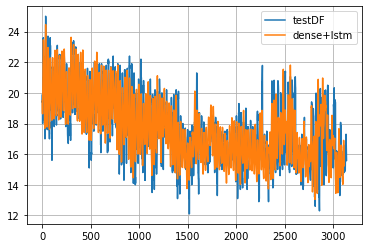

In [66]:
### the offseted prediction works wonders -offset by 24 hours-
plt.plot(test_labels[['Ts_Valor']],label='testDF')
plt.plot(X[['Ts_Valor']],label='dense+lstm')
plt.grid()
plt.legend()
plt.show()

In [370]:
a = (X - test_labels).mean()
a

HR_Valor    -0.543562
QFE_Valor    0.050571
Ts_Valor    -0.278398
day               NaN
hour              NaN
month             NaN
dtype: float64

## Evaluación

Ídem a iteraciones anteriores, estos valores de error promedio no son suficientes para asegurar la calidad del modelo, se debe evaluar su capacidad de retroalimentación en tiempo real, por lo tanto se genera un nuevo proceso de retroalimentación

In [74]:
now = datetime.datetime.now()
now = pandas.to_datetime('2021-07-29 09:00:00')
now = pandas.to_datetime('2021-03-23 06:00:00')
df3 = train_df[-24:]
stackPreds = pandas.DataFrame()
lastTrainBatch = train_df[-24:]
# now reshape this lastTrainBatch to meet what input_shape the model expects
lastTrainBatch = lastTrainBatch.reshape((1,winSize,numFeatures))
x = nnHM.predict(lastTrainBatch)

In [75]:
def norm(value,index):
    #value = (value - modelMean[index]) / modelStd[index]
    value = (value - train_mean[index]) / train_std[index]
    return value

In [76]:
for i in range(0,72):
    delta = now + datetime.timedelta(0,i*3600)
    #temp = np.array([x,y,z,delta.hour,delta.day,delta.month],dtype="float32")
    # temp = np.array([x,y,z,norm(delta.hour,3),norm(delta.day,4),norm(delta.month,5)],dtype="float32")
    temp = np.array([x[0,0],x[0,1],x[0,2],norm(delta.hour,3),norm(delta.day,4),norm(delta.month,5)],dtype="float32")
    stackPreds = stackPreds.append(pandas.DataFrame(temp).transpose())
    # df3 = np.vstack((df3[0],temp))
    # df4 = np.vstack((df4,temp))
    cde = np.reshape(df3,(24,6))
    df3 = np.vstack((cde,temp))
    df3 = np.delete(df3, (0), axis=0)
    df3 = np.reshape(df3,(-1,24,6))
    x = nnHM.predict(df3)

In [77]:
stackPreds = stackPreds.reset_index(drop=True)
stackPreds.columns = ['Ts_Valor','HR_Valor','QFE_Valor','hour','day','month']
stackPreds = stackPreds*train_std+train_mean
# stackPreds

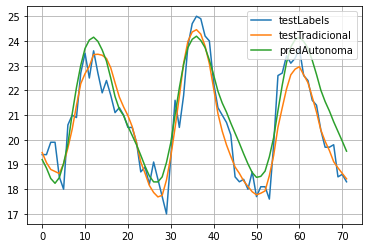

In [80]:
plt.plot(test_labels['Ts_Valor'][0:72], label='testLabels')
plt.plot(X[['Ts_Valor']][0:72],label='testTradicional')
plt.plot(stackPreds['Ts_Valor'],label='predAutonoma')
plt.legend()
plt.grid()
plt.show()

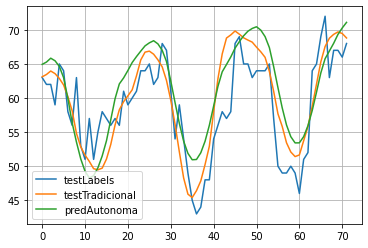

In [81]:
plt.plot(test_labels['HR_Valor'][0:72], label='testLabels')
plt.plot(X[['HR_Valor']][0:72],label='testTradicional')
plt.plot(stackPreds['HR_Valor'],label='predAutonoma')
plt.legend()
plt.grid()
plt.show()

In [380]:
a = stackPreds - test_labels[:72]
a.mean()

HR_Valor     7.588925
QFE_Valor    1.922293
Ts_Valor    -4.633723
day               NaN
hour              NaN
month             NaN
dtype: float64